### Data

In [1]:
from tqdm.auto import tqdm
from datasets import load_dataset
import numpy as  np
from transformers import GPT2Tokenizer

In [2]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
dataset = load_dataset('wikitext', 'wikitext-103-v1')
split = dataset['train']

In [ ]:
# compute text with token length >= 512
batch = 500
min_tok_length = 512
filtered = []
lengths = []
max_length = 0
for i in tqdm(range(0, len(split), batch)):
    lengths += [len(tok) for tok in tokenizer.batch_encode_plus([split[min(i+j, len(split) - 1)]['text'] for j in range(batch)])['input_ids']]

In [ ]:
np.save('token_length.npy', np.array(lengths))

In [3]:
l = np.load('token_length.npy')

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
all([len(tok) > 512 for tok in tokenizer.batch_encode_plus([split[int(i)]['text'] for i in np.where(l > 512)[0][:20]])['input_ids']])

True

### Apply to MHA (GPT2 WikiText)

In [6]:
import torch
import torch.nn as nn
import numpy as np
from transformers.models.gpt2.modeling_gpt2 import GPT2Attention
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import transformers_drop_in as drop_in
import tensor_util as tu
from config import CONFIG

In [7]:
CONFIG.do_consolidate = True
CONFIG.consolidate_ratio = 0.5
CONFIG.context_length = 400
CONFIG.consolidate_length = 200
CONFIG.temperature = 0.1
CONFIG.fix_prune_rate = True

In [8]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2').to(CONFIG.device)
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2AttentionDropIn(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [9]:
batch_size = 1
indices, = np.where(l > CONFIG.context_length)
batch_iter = iter(np.array_split(np.random.choice(indices, len(indices), replace=False), len(indices) // batch_size))

In [10]:
n_layer = 12
drop_in.GLOBALS.outputs = {
    'unnormalized': [[] for _ in range(n_layer)],
    'eig': [[] for _ in range(n_layer)],
    'final': [[] for _ in range(n_layer)],
    'value': [[] for _ in range(n_layer)],
    'query': [[] for _ in range(n_layer)],
    'key': [[] for _ in range(n_layer)],
    'out': [[] for _ in range(n_layer)],
    'mask': [[] for _ in range(n_layer)],
}
def record_attn(layer_idx, query, key, value, unnormalized_attn, final_attn, attn_output, attn_mask):
    # drop_in.GLOBALS.outputs['unnormalized'][layer_idx] += [unnormalized_attn.cpu()]
    drop_in.GLOBALS.outputs['final'][layer_idx] += [final_attn.cpu()]
    drop_in.GLOBALS.outputs['value'][layer_idx] += [value.cpu()]
    drop_in.GLOBALS.outputs['query'][layer_idx] += [value.cpu()]
    drop_in.GLOBALS.outputs['key'][layer_idx] += [value.cpu()]
    drop_in.GLOBALS.outputs['out'][layer_idx] += [attn_output.cpu()]
    # drop_in.GLOBALS.outputs['mask'][layer_idx] += [attn_mask.cpu()]

def no_op(layer_idx, query, key, value, unnormalized_attn, final_attn, attn_output, attn_mask):
    pass

drop_in.record_attn_vars = no_op

In [17]:
n_sample = 1
n_layer = 12
cols = 4
rows = n_layer // cols
rank_by_layer = [[] for _ in range(n_layer)]
with torch.no_grad():
    for i in tqdm(range(n_sample)):
        batch = next(batch_iter)
        model_input = {name: t.to(CONFIG.device) for name, t in tokenizer.batch_encode_plus(split[batch]['text'],
                                                                                         return_tensors="pt",
                                                                                         truncation=True,
                                                                                         max_length=CONFIG.context_length).items()}
        model(**model_input)

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
keys = torch.stack([torch.cat(t, dim=0) for t in drop_in.GLOBALS.outputs['key']], dim=2)
keys = keys.reshape(-1, *keys.shape[-3:])  # [ batch * num heads X layers X L X d ]
keys.shape

torch.Size([12, 12, 400, 64])

In [70]:
diag_mask = torch.diag(torch.ones(CONFIG.context_length, dtype=torch.bool))
keys_n = keys / ((keys ** 2).sum(dim=-1) ** 0.5)[...,None]
ksim = keys_n @ keys_n.transpose(-2, -1)
ksim_sm = torch.softmax(ksim, dim=-1)
max_other_ksim_sm = ksim_sm[:,:,~diag_mask].reshape(*ksim_sm.shape[:3], -1).max(dim=-1).values
max_ksim_sm_ratio = max_other_ksim_sm / ksim_sm[:,:,diag_mask]
ksim.shape, max_ksim_sm_ratio.shape

(torch.Size([12, 12, 400, 400]), torch.Size([12, 12, 400]))

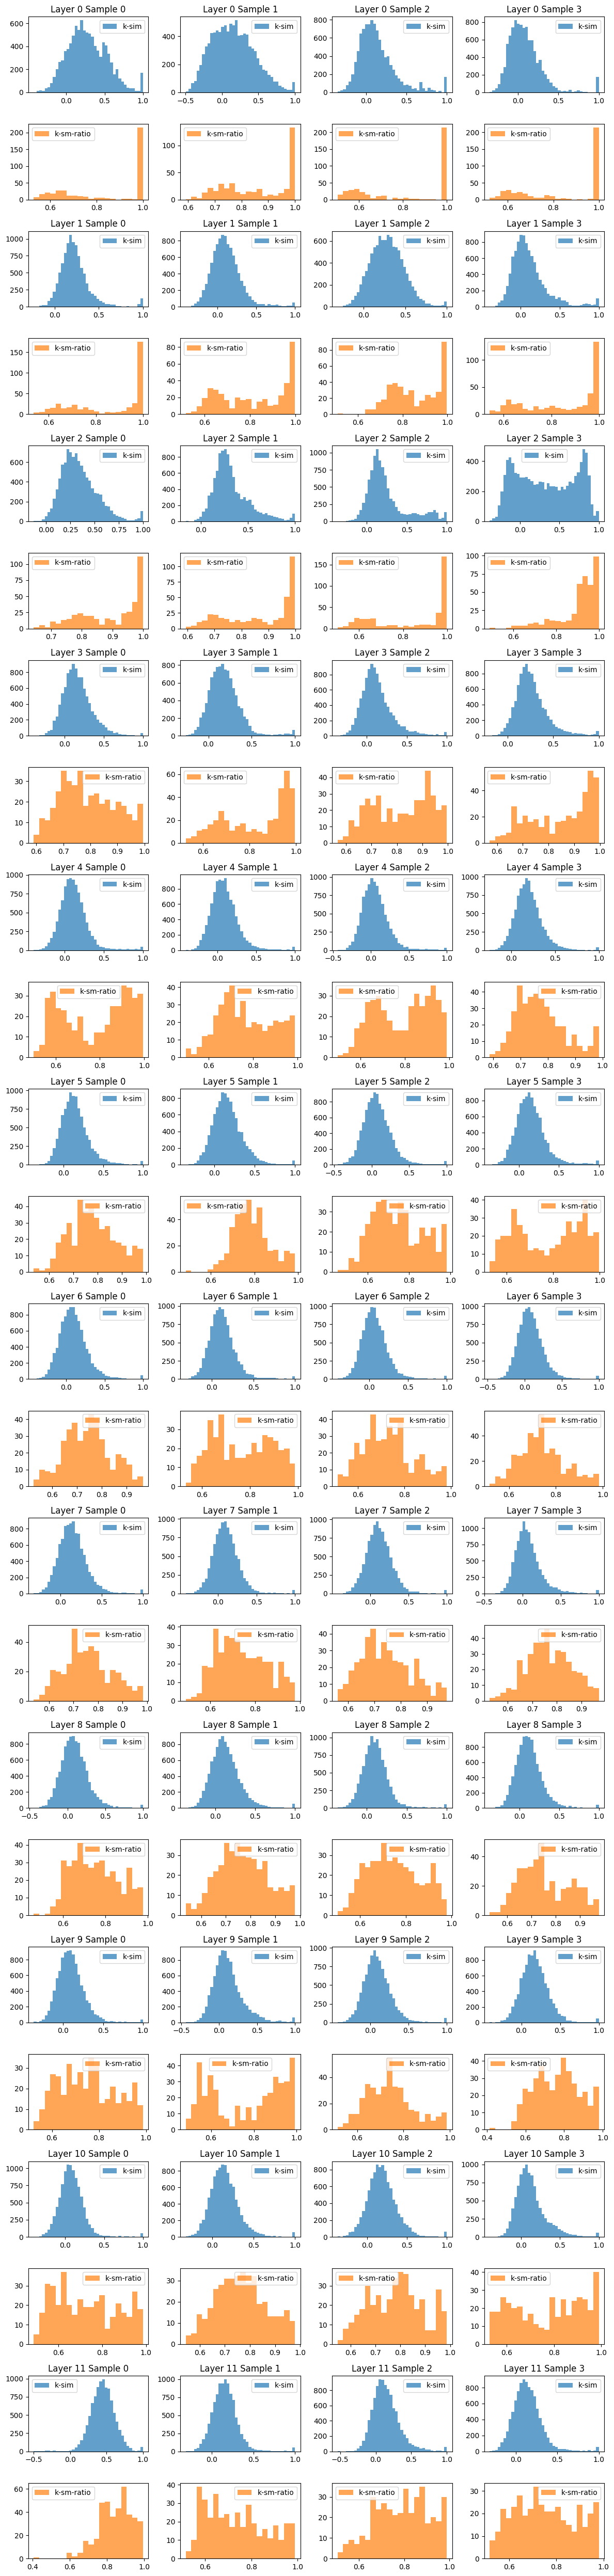

In [77]:
n_sample = 4
ksim_n_sample = 10_000
n_layer = 12
alpha = 0.7
f, ax = plt.subplots(n_layer * 2, n_sample, figsize=(12, 50))
for i, idx in enumerate(np.random.choice(ksim.size(0), n_sample, replace=False)):
    for layer in range(n_layer):
        ksim_sample = np.random.choice(ksim[idx,layer,~ksim_mask], ksim_n_sample, replace=False)
        ax[2*layer,i].hist(ksim_sample, bins=40, label="k-sim", alpha=alpha)
        ax[2*layer+1,i].hist(max_ksim_sm_ratio[idx,layer], bins=20, label="k-sm-ratio", alpha=alpha, color="#ff7f0e")
        ax[2*layer,i].set_title(f"Layer {layer} Sample {i}")
        ax[2*layer,i].legend()
        ax[2*layer+1,i].legend()
f.tight_layout()

### Test K-consolidation effect on PPL

In [82]:
KSIM_T = 0.9  # 1 - 1e-6
L2_AGG = False

max_errors = {}
last_kv = {}

consolidation_layerwise = [[] for _ in range(n_layer)]

def consolidate_by_ksim(layer_idx, key, value):
    global max_errors
    last_kv['k'] = key
    last_kv['v'] = value
    L = CONFIG.consolidate_length
    diag_mask = torch.diag(torch.ones(L, dtype=torch.bool))
    consolidate_k = key[...,:L,:]
    consolidate_v = value[...,:L,:]
    keys_l2 = ((consolidate_k ** 2).sum(dim=-1) ** 0.5)[...,None]  # [ ... X L X 1 ]
    keys_n = consolidate_k / keys_l2
    ksim = keys_n @ keys_n.transpose(-2, -1)  # [ ... X L X L ]

    #ksim_sm = torch.softmax(ksim, dim=-1)
    #max_other_ksim_sm = ksim_sm[:,:,~diag_mask].reshape(*ksim_sm.shape[:3], -1).max(dim=-1).values
    #max_ksim_sm_ratio = max_other_ksim_sm / ksim_sm[:,:,diag_mask]

    # mixing consolidation
    cluster_mask = (ksim >= KSIM_T).type(torch.float)
    if L2_AGG:
        consolidate_k = (cluster_mask @ (keys_n ** 2)) ** 0.5
    else:
        consolidate_k = cluster_mask @ keys_n

    # re-weight aggregated key vectors by original L2-norm
    consolidate_k = consolidate_k * keys_l2

    # weight value vectors by exponential L2-norm of corresponding k when consolidating
    exp_l2 = torch.exp(keys_l2.type(torch.float64))
    cluster_mask = cluster_mask.type(torch.float64)
    consolidate_v = (cluster_mask @ (consolidate_v.type(torch.float64) * exp_l2)) / (cluster_mask @ exp_l2)
    consolidate_v = consolidate_v.type(torch.float32)

    # return consolidate KVs concatenated to remaining KVs
    new_k, new_v = (
        torch.cat([consolidate_k, key[...,L:,:]], dim=-2),
        torch.cat([consolidate_v, value[...,L:,:]], dim=-2),
    )
    consolidation_layerwise[layer_idx] += [cluster_mask[...,~diag_mask].sum().item() / cluster_mask.numel()]
    if layer_idx == 0:
        max_errors = {}
    max_errors[layer_idx] = max((key - new_k).abs().max(), (value - new_v).abs().max())
    # assert (key - new_k).abs().max() < 1e-5, f"Max error: {(key - new_k).abs().max()}"
    # assert (value - new_v).abs().max() < 1e-5, f"Max error: {(value - new_v).abs().max()}"
    return new_k, new_v

drop_in.consolidate_kv = consolidate_by_ksim

In [83]:
CONFIG.do_consolidate = True
batch_size = 1
no_loss_label = -100
nlls = []
with torch.no_grad():
    for i, batch in enumerate(tqdm(np.array_split(indices, len(indices) // batch_size))):
        model_input = {name: t.to(CONFIG.device) for name, t in tokenizer.batch_encode_plus(split[batch]['text'],
                                                                                     return_tensors="pt",
                                                                                     truncation=True,
                                                                                     max_length=CONFIG.context_length).items()}
        labels = model_input['input_ids'].clone()
        labels[:,:CONFIG.consolidate_length] = no_loss_label
        out = model(**model_input, labels=labels)  # forward pass handles predicted token time shift
        nlls += [out.loss]
        if i > 30:
            break
consolidation_mass_by_layer = [np.mean(consolidation_layerwise[i]) for i in range(n_layer)]
ppl = torch.exp(torch.stack(nlls).mean())

  0%|          | 0/7626 [00:00<?, ?it/s]

tensor(29.0926, device='cuda:0')

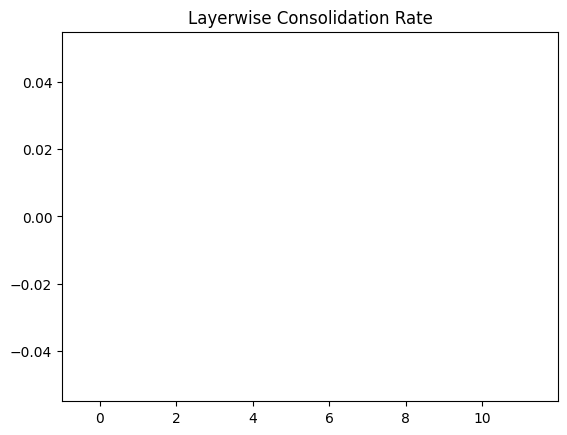

In [77]:
plt.bar(range(n_layer), consolidation_mass_by_layer)
plt.title("Layerwise Consolidation Rate")
ppl  # t = 1.

tensor(33.4164, device='cuda:0')

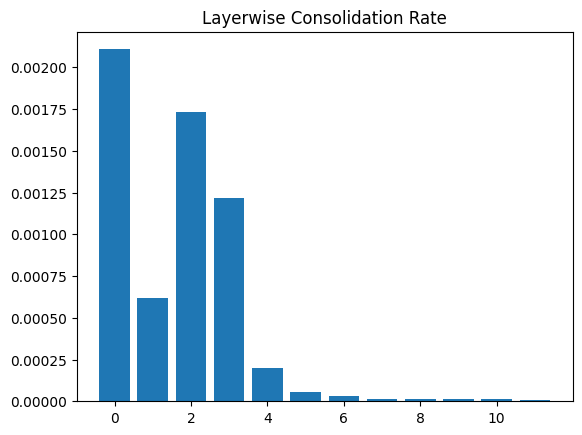

In [81]:
plt.bar(range(n_layer), consolidation_mass_by_layer)
plt.title("Layerwise Consolidation Rate")
ppl  # t = 0.99

tensor(213.8772, device='cuda:0')

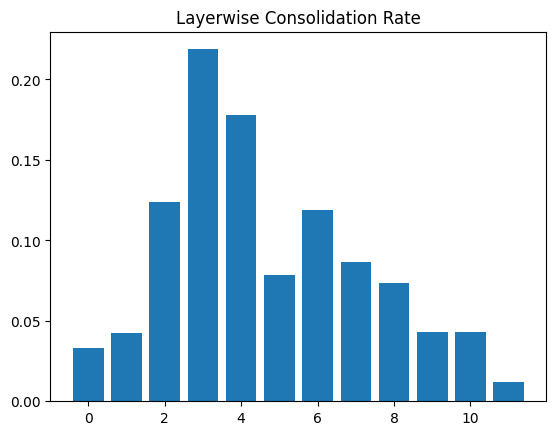

In [84]:
plt.bar(range(n_layer), consolidation_mass_by_layer)
plt.title("Layerwise Consolidation Rate")
ppl  # t = 0.9

Any quantifiable reduction in KV cache comes with massive PPL increase